In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [5]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [6]:
users = pd.read_csv('data/users.csv') # Информация о городе проживания пользователя:
print('Users: ', users['user_id'].nunique())
users.head(3)

Users:  1252801


,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk


In [7]:
orgs = pd.read_csv('data/organisations.csv') # Описание извлекаемых из отзывов аспектов. 
# Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.
print('Orgs: ', orgs['org_id'].nunique())
orgs.city.value_counts()

Orgs:  66405


msk    44229
spb    22176
Name: city, dtype: int64

`organisations.csv` - Информация об организациях:

* `org_id:` идентификатор организации
* `city_id:` город организации
* `average_bill:` средний чек в рублях (округленный с точностью до 500 рублей)
* `avg_rating:` средний рейтинг (в том числе с учетом не перечисленных в файле reviews.csv отзывов и оценок)
* `rubric_id:` рубрика опрганизации
* `feature_ids:` набор известных особенностей данной организации.

In [8]:
columns = ['rubrics_id', 'features_id'] # create lists
apply_to_columns(orgs, columns)
orgs.sample(3)

,org_id,city,average_bill,rating,rubrics_id,features_id
17409,16299465435738529402,msk,500.0,5.000000,[31495],"[1018, 11629, 11704, 11867, 20422, 273469383]"
24031,11911484091594563571,msk,1500.0,3.907407,"[30776, 30770]","[246, 256, 444, 601, 1018, 1509, 10770, 10875,..."
25508,18119542865977139956,spb,500.0,4.250000,[30774],"[1018, 11177, 11629, 11704, 11867, 20422, 2734..."


In [35]:
def count_feature(x):
    try:
        return len(x)
    except:
        return -1
    
    
orgs['feature_count'] = orgs['features_id'].apply(count_feature)

In [45]:
# orgs.feature_count.hist()
orgs.average_bill.value_counts()

500.0      21658
1000.0      5366
1500.0      2618
2000.0      1157
2500.0       394
           ...  
18500.0        1
26500.0        1
12000.0        1
26000.0        1
57500.0        1
Name: average_bill, Length: 63, dtype: int64

Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы - `reviews.csv` - обучающее множество собрано за `X = 1217` дней, тестовое множество – за последующие `Y = 107` дней.

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода:

* `user_id`: идентификатор пользователя
* `org_id`: идентификатор организации
* `ts`: время отзыва (в днях от начала обучающего периода)
* `rating`: поставленная оценка
* `aspect_ids`: набор упомянутых в тексте отзыва аспектов.

In [10]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

print('Reviews: ', len(reviews))
print('Users review: ', reviews.user_id.nunique())

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id', how='left')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

orgs.rename({'rating': 'org_rating'}, axis=1, inplace=True)

reviews = reviews.merge(orgs[['org_id', 'city','org_rating']], on='org_id', how='left') # encode orgs ids as numeric
reviews = reviews.rename({'city': 'org_city'}, axis=1)




columns = ['aspects'] # create lists
apply_to_columns(reviews, columns)

len_before_drop_duplics = len(reviews)
reviews.drop_duplicates(['user_id', 'org_id','rating','ts','user_city','org_city'], inplace=True) # Удаляем дубли
len_after_drop_duplics = len(reviews)
print('Выброшено дублей: ', len_before_drop_duplics - len_after_drop_duplics)

reviews.sample(10)

Reviews:  3640835
Users review:  1252801
Выброшено дублей:  58038


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating
3066928,779821309871812671,9104453017196776235,5.0,468,NaN,msk,msk,4.638082
1512076,15764618901349348800,9104453017196776235,5.0,1186,NaN,msk,msk,4.638082
837899,15816811522781448429,3692097371896759173,5.0,1150,"[250, 251, 380]",msk,msk,4.619375
791317,15548364093449485417,4685886609621075007,4.0,1061,NaN,msk,msk,4.413026
1503516,11909877485358806512,150402034505515914,5.0,967,NaN,msk,msk,4.676271
2219174,13696945103541975465,2826762492126814166,5.0,477,NaN,msk,msk,4.100471
1248079,14149386853109135563,14292913557677356498,5.0,341,NaN,spb,spb,2.428571
3204893,17731208328422883413,15372028115717330147,5.0,1188,NaN,msk,msk,4.777778
841587,12078908082393052097,2257593444673431506,5.0,958,NaN,spb,spb,4.352217
3360372,13870145526832254159,9625558126235546789,5.0,767,"[12, 271, 306]",spb,spb,4.627451


**Отлично, теперь с отзывами будет удобно работать.**  Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

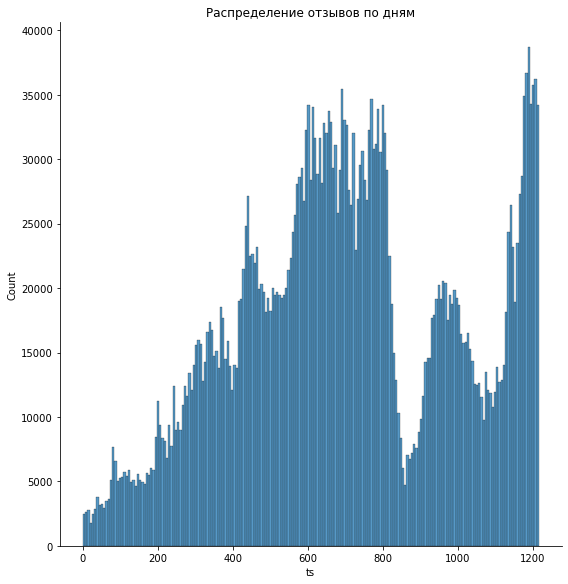

In [11]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [12]:
from func import clear_df, extract_unique, count_unique, filter_reviews, train_test_split, process_reviews

In [13]:
reviews['ts'].max()

1216

**Всего в выборку попали отызывы за 1216 дней.**  Отложим в тестовую выборку отзывы за последние **100** дней.

In [14]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [15]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**. `print_score` домножает реальное значение метрики на `100` так же, как и в контесте. Подобная имплементация используется для оценки **submission**.

In [16]:
from func import MNAP, print_score

In [17]:
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [51]:
# spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
# msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [52]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [53]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.24


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [54]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [55]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.44


Метрика улучшилась ещё немного!

# N самых популярных мест среди туристов с учетом оценки заведения

In [74]:
tourist_reviews = train_reviews[(train_reviews['rating'] >= 4.0) & (train_reviews['org_rating'] >=  4.0)]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [75]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.50


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [58]:
from func import extract_top_by_rubrics

In [59]:
orgs.head(2)

,org_id,city,average_bill,org_rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."


In [60]:
msk_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [61]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.73


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении `i`-ой строки и `j`-ого столбца будет рейтинг, который `i`-ый пользователь выставил `j`-ой организации или же пропуск, если рейтинг не был установлен. 

In [22]:
from func import reduce_reviews, create_mappings, map_ids, interaction_matrix

## ALS

In [23]:
import implicit  # !pip install implicit

In [66]:
def make_predictions(interactions, X_test, N):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    
  
    
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=5, 
        iterations=300, 
        regularization=0.01, 
        random_state=42,
        num_threads = 4,
        calculate_training_loss=True

    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()

In [67]:
mean_rating = train_reviews['rating'].mean()
train_reviews['rating'].fillna(mean_rating, inplace=True)


train_reviews = train_reviews[train_reviews['rating'] >= 3]
 
# train_reviews.dropna(inplace=True)
train_reviews.rating.isnull().sum()

0

In [68]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

spb_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'spb'],
                                      city = 'spb')       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

Собираем матрицу взаимодействий: all_users: 27327 all_orgs: 13640
Собираем матрицу взаимодействий: all_users: 20793 all_orgs: 13640


In [69]:
# sp_m = pd.DataFrame.sparse.from_spmatrix(msk_interactions[0])
# sp_m.isnull().sum().sum()
# del sp_m

In [70]:
# 100*train_reviews.rating.isnull().sum()/len(train_reviews.rating.isnull()

In [71]:
msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

In [72]:
print_score(MNAP_N(y_test, predictions))

Score: 0.82


# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

**Формат вывода:**
Для каждого пользователя из файла `test_users.csv` необходимо приложить список из не более чем 20 организаций, относящихся к городу, отличному от города проживания пользователя.

## Without ML

In [65]:
# набор отзывов только от туристов


tourist_reviews = reviews[(reviews['rating'] >= 4.0) & (reviews['org_rating'] >= 4.0)]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [67]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']
test_users.head()

,user_id,city
0,3545210947248911048,msk
1,15271987121288045390,msk
2,15016858616184265932,msk
3,12457244142928722989,msk
4,13339684649926251468,spb


In [68]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)

predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

predictions.to_csv('answers.csv', index=None)

## With ML

In [34]:
# mean_rating = reviews['rating'].mean()
# reviews['rating'].fillna(mean_rating, inplace=True)
# reviews = reviews[reviews['rating'] > 3]
# reviews

,user_id,org_id,rating,ts,aspects,user_city,org_city
4,2035736119522953868,7143808482480365209,5.0,1185,NaN,spb,spb
5,2549680087122219670,12820757337968119145,5.0,1061,"[9, 10]",spb,msk
7,11502321723490708343,5094937364114858089,5.0,1148,NaN,msk,msk
8,780616808613468272,8786304251059473262,5.0,544,NaN,spb,spb
9,16728765660072935007,390155533569470039,5.0,910,NaN,msk,msk
...,...,...,...,...,...,...,...
3640828,11318628811387673806,2122003809299736605,5.0,1175,NaN,msk,msk
3640829,3158913909313862945,11326158391867036288,5.0,978,"[4, 11]",msk,msk
3640832,8928726821194342760,12046097390037935713,4.0,424,NaN,msk,spb
3640833,13307262877386644281,4362229515870954070,5.0,618,NaN,msk,msk


In [35]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')


test_msk_users = test_users[test_users['city'] == 'msk'][['user_id', 'city']]
test_spb_users = test_users[test_users['city'] == 'spb'][['user_id', 'city']]


#reviews.dropna(inplace=True) # Мое изменение

msk_interactions = interaction_matrix(
    reviews,                                  
    test_msk_users,
    city = 'msk'
)

spb_interactions = interaction_matrix(
    reviews,
    test_spb_users,
    city = 'spb'
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

Собираем матрицу взаимодействий: all_users: 34864 all_orgs: 15332
Собираем матрицу взаимодействий: all_users: 23913 all_orgs: 15332


In [36]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head()

,user_id,target
0,3545210947248911048,13225228120465186798 16871305338968936919 6509...
1,15271987121288045390,18040307346204360188 15316007586268055942 3853...
2,15016858616184265932,15250345250621165867 13573322486152844808 5964...
3,12457244142928722989,18040307346204360188 9520432662741693338 38531...
4,16511650156158419042,16675539430563158860 17653269096693532910 4597...


In [37]:
predictions.to_csv('answers_ml.csv', index=None)

In [38]:
predictions['target'][0]

0    13225228120465186798 16871305338968936919 6509...
0    8703960512392877552 6509663389247272810 129097...
Name: target, dtype: object

# SVD и другие

# NLP данные

In [3]:
# !pip install lightfm

# LightFM

In [4]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()
test_precision

2021-10-03 14:02:58,632 [8884] WARNING  py.warnings:109: [JupyterRequire] C:\Users\sasha\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(



In [14]:
 data['train'].toarray().shape

(943, 1682)

In [15]:
 data['test'].toarray().shape

(943, 1682)